Copy of 8 fixing the 1/2 on the loss

In [1]:
AEversion = '9'

In [2]:
import numpy as np
import os, sys, pickle
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

imperium-sm.hep.caltech.edu  Tue Jul 16 08:09:24 2019
[0] GeForce GTX 1080 | 22'C,   0 % |  2422 /  8119 MB | ocerri(2411M)
[1] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[2] GeForce GTX 1080 | 26'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 22'C,   0 % |    11 /  8119 MB |
[4] GeForce GTX 1080 | 26'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 26'C,   0 % |    11 /  8119 MB |


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sys.path.append('../lib')
from progressBar import ProgressBar
from utils import EarlyStopping, createROC_curve, ELU_ProbNorm

In [6]:
dnd = []

## Get the dataset

In [7]:
from dataLoaders import ParticleDataset

In [8]:
dataset = ParticleDataset(template='../data/20190708_50part_PtOrder_v2/{}.npy', N_part=50, N_features=5)

In [9]:
dataset.loadTrainSM(N_train_max=1e7)
dataset.charge(dataset.SMMix_train)

Fetching Wlnu
Fetching qcd
Fetching Zll
Fetching ttbar
QCD is limiting, using it for both val and split
Expected 3.38M train
Expected 3.38M val

Loading Wlnu
Reloading QCD for validation
Loading Zll
Loading ttbar
+--------+----------+-------+-------+
| Sample | Evts tot | Train |  Val  |
+--------+----------+-------+-------+
|  Wlnu  |  4000k   | 2000k | 2000k |
|  qcd   |  1166k   | 1142k | 1142k |
|  Zll   |  1000k   |  226k |  226k |
| ttbar  |  1000k   |  10k  |  10k  |
+--------+----------+-------+-------+
Tot training 3.38 M
Tot val 3.38 M


In [10]:
dataset.loadValidationSamples('BSM')

Loading Ato4l (47.7k)
Loading leptoquark (273.6k)
Loading hToTauTau (681.8k)
Loading hChToTauNu (338.5k)


## Define the model

In [11]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=(self.p+3)*self.No,
                                   dim_hidden=dim_hidden),
            'ChargeDec': self.build_dense(dim_in=2,
                                   dim_out=3),
            'pdgIdDec': self.build_dense(dim_in=2,
                                   dim_out=5)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-5, max_val=5)
        return z
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p+3)
        
        # --- Formatting x ----
        # pt
        pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        sig_pt = 1. + 1e-6 + F.elu(x_raw[:,:,1]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,2], min_val=-5, max_val=5).view(-1, self.No, 1)
        sig_eta = 1. + 1e-6 + F.elu(x_raw[:,:,3]).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,4]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        sig_phi = 1. + 1e-6 + F.elu(x_raw[:,:,5]).view(-1, self.No, 1)
        # charge
#         charge_cat = F.softmax(self.decoder_modules['ChargeDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 3)
        charge_cat = ELU_ProbNorm(self.decoder_modules['ChargeDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 3)
        # pId
#         pId_cat = F.softmax(self.decoder_modules['pdgIdDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 5)
        pId_cat = ELU_ProbNorm(self.decoder_modules['pdgIdDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 5)
        
        x = torch.cat((pt, eta, phi, sig_pt, sig_eta, sig_phi, charge_cat, pId_cat), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            os.environ['CUDA_VISIBLE_DEVICES'] = str(N_GPU)
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [12]:
Latent_dimension = int(0.3*dataset.inputs.shape[1])
Hidden_dimension = int(0.25*(Latent_dimension + dataset.inputs.shape[1]*dataset.inputs.shape[2]))

model = AEDenseNet(
                   N_part=dataset.inputs.shape[1],
                   N_features=dataset.inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=250, out_features=66, bias=True)
      (1): ReLU()
      (2): Linear(in_features=66, out_features=66, bias=True)
      (3): ReLU()
      (4): Linear(in_features=66, out_features=15, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (ChargeDec): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=3, bias=True)
    )
    (PhiD): Sequential(
      (0): Linear(in_features=15, out_features=66, bias=True)
      (1): ReLU()
      (2): Linear(in_features=66, out_features=66, bias=True)
      (3): ReLU()
      (4): Linear(in_features=66, out_features=400, bias=True)
    )
    (pdgIdDec): Sequential(
      (0): Linear(in_features=2, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=5, bias=True)
    )
  )
)

Trainable parameters: 54315


In [13]:
model.useGPU(int(AEversion)%8)

Current device: 0 (8 available)
imperium-sm.hep.caltech.edu  Tue Jul 16 08:09:55 2019
[0] GeForce GTX 1080 | 22'C,   0 % |  2422 /  8119 MB | ocerri(2411M)
[1] GeForce GTX 1080 | 28'C,   4 % |   468 /  8119 MB | ocerri(457M)
[2] GeForce GTX 1080 | 26'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 22'C,   0 % |    11 /  8119 MB |
[4] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 26'C,   0 % |    11 /  8119 MB |


## Loss

In [14]:
def criterion(x_in, x_out, reduction='mean'):
    # Gaussian
    out_gauss = 0.5*torch.pow((x_in[:,:,:3] - x_out[:,:,:3])/ x_out[:,:,3:6], 2) + torch.log(x_out[:,:,3:6])
    out = torch.sum(out_gauss, dim=2)
    
    #Cat cross entropy charge
    aux = torch.log(x_out[:,:,6:9]).view(-1, 3)
    aux = F.nll_loss(aux, 1+x_in[:,:,3].view(-1).long(), reduction='none')
    out += aux.view(-1, x_in.shape[1])
    
    #Cat cross entropy pId
    aux = torch.log(x_out[:,:,9:14]).view(-1, 5)
    out += F.nll_loss(aux, x_in[:,:,4].view(-1).long(), reduction='none').view(-1, x_in.shape[1])
    
    out_per_evt = torch.sum(out, dim=1)
    
    if reduction == 'mean':
        return torch.mean(out_per_evt)
    elif reduction == 'none':
        return out_per_evt
    else:
        raise

## Training

In [15]:
training_params = {'batch_size': 10000,
                   'shuffle': True,
                   'num_workers': 3
                  }

max_epochs = 1000

eval_params = {'batch_size': 50000,
               'num_workers': 3
              }

In [16]:
# torch.autograd.set_detect_anomaly(True);

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=10)

In [18]:
train_loss = []
BSM_eff = {'ep': []}
for n in dataset.BSM_names:
    BSM_eff[n] = []

loss_history = {'train': [], 'val': []}
optimizer.zero_grad()
try:
    for epoch in range(max_epochs):
        batch_loss = []

        #### ---- Training ---- ####
        model.train()
        dataset.charge(dataset.SMMix_train)
        train_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
        pb = ProgressBar(len(train_data_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch))
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)

            x_prime = model(local_x)        
            loss = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid training loss!!!')
                raise NameError('LossNAN')
            batch_loss.append(loss.item())

            tail_label = 'Loss: {:2.2e}'.format(loss.item())
            if len(loss_history['train']) > 0:
                tail_label += ' ({:2.2e})'.format(loss.item() - loss_history['train'][-1][-1])
            pb.show(len(batch_loss)-1, tail_label=tail_label)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        aux_loss = 0
        N_batches = 0
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            loss = criterion(local_x, x_prime)
            aux_loss += loss.item()
            N_batches += 1
        batch_loss.append(aux_loss/N_batches)

        printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
        if len(loss_history['train']) > 0:
            printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - loss_history['train'][-1][-1])
        if len(loss_history['train']) > 1:
            d2L_de2 = batch_loss[-1] - 2*loss_history['train'][-1][-1] + loss_history['train'][-2][-1]
            printout +=' - Trend: {:2.2e}'.format(d2L_de2)
        print(printout)

        loss_history['train'].append(batch_loss)

        #### ---- Validation ---- ####
        dataset.charge(dataset.SMMix_val)
        val_data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
        aux_loss = 0
        N_batches = 0
        for local_x, _ in val_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            loss = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid validation loss!!!')
                raise NameError('LossNAN')
            aux_loss += loss.item()
            N_batches += 1
        loss_history['val'].append(aux_loss/N_batches)
        printout = 'Val Loss: {:2.2e}'.format(loss_history['val'][-1])
        print(printout)
        if epoch > 0:
            if loss_history['val'][-1] < np.min(loss_history['val']):
                print('[INFO]: Saving best model')
                torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_best.pkl')

        print('')
        if not earlyStopping.check(loss_history['val'][-1]):
            break

        scheduler.step(batch_loss[-1])
        
        #### ---- Periodic save model ---- ####
        if epoch%50 == 0:
            torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_epoch{}.pkl'.format(epoch))

        #### ---- Anomaly Detection monitor ---- ####
        if epoch%3 == 0:
            print('------------ Anomaly Detection monitor ------------')
            BSM_eff['ep'].append(epoch)
            dataset.loss['SMMix'] = np.zeros((0))

            pb = ProgressBar(len(val_data_iter), percentPrecision=5, headLabel='SM Mix: ')
            for i, (local_x, _) in enumerate(val_data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss['SMMix'] = np.concatenate((dataset.loss['SMMix'], loss))

            p_SM = np.logspace(base=10, start=-5, stop=-3, num=3)
            if not 'p_SM' in BSM_eff.keys():
                BSM_eff['p_SM'] = p_SM
            q_SM = np.quantile(dataset.loss['SMMix'], 1-p_SM)

            table = PrettyTable(['SM Mix'] + list(map(lambda x: '{:1.2e}'.format(x), p_SM)))

            for n in dataset.BSM_names:
                dataset.loss[n] = np.zeros((0))

                dataset.charge(dataset.valSamples[n])
                data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
                pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
                for i, (local_x, _) in enumerate(data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

                out = dataset.loss[n] > np.atleast_2d(q_SM).T
                p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/dataset.loss[n].shape[0])
                BSM_eff[n].append(p_BSM)

                table.add_row([n] + list(map(lambda x: '{:1.2e}'.format(x), p_BSM)))
            print(table)                
            print('---------------------------------------------------\n\n')

    model.eval()
    torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'.pkl');
except NameError:
    if epoch > 0:
        print ('\n\nModel ended up nan. Recovering best model\n')
        model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_best.pkl'))
    else:
        raise

Epoch 0: [####################]  100% - Tot. time: 15.9 s           
Loss: 1.09e+02
Val Loss: 1.09e+02

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 18.9 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 2.9 s
hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-05 | 2.33e-03 | 3.18e-02 |
| leptoquark | 4.02e-05 | 8.88e-04 | 1.64e-02 |
| hToTauTau  | 5.37e-04 | 4.90e-03 | 4.35e-02 |
| hChToTauNu | 9.37e-04 | 7.93e-03 | 5.91e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 1: [####################]  100% - Tot. time: 16.0 s                       
Loss: 5.41e+01 - Delta: -5.47e+01
Val Loss: 5.43e+01

Epoch 2: [####################] 

Epoch 20: [####################]  100% - Tot. time: 17.3 s                       
Loss: 1.41e+01 - Delta: 1.53e+00 - Trend: 3.95e+00
Val Loss: 1.42e+01

Epoch 21: [####################]  100% - Tot. time: 19.9 s                       
Loss: 1.13e+01 - Delta: -2.78e+00 - Trend: -4.31e+00
Val Loss: 1.14e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.6 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.6 s
hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 5.66e-04 | 1.79e-02 |
| leptoquark | 1.10e-04 | 1.06e-03 | 1.40e-02 |
| hToTauTau  | 5.75e-04 | 5.03e-03 | 3.46e-02 |
| hChToTauNu | 1.06e-03 | 8.59e-03 | 4.86e-02 |
+------------+----------+----------+----------+
-----------------

Epoch 40: [####################]  100% - Tot. time: 17.6 s                       
Loss: 8.10e+00 - Delta: 4.35e+00 - Trend: 9.76e+00
Val Loss: 8.26e+00

Epoch 41: [####################]  100% - Tot. time: 17.9 s                       
Loss: 3.02e+00 - Delta: -5.08e+00 - Trend: -9.43e+00
Val Loss: 3.19e+00

Epoch 42: [####################]  100% - Tot. time: 19.8 s                       
Loss: 2.69e+00 - Delta: -3.31e-01 - Trend: 4.75e+00
Val Loss: 2.86e+00

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 23.9 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.26e-04 | 2.70e-03 | 3.35e-02 |
| leptoquark | 5.48e-05 | 1.18e-03 | 1.78e-02 |
| hToTa

hToTauTau: [##############]  100% - Tot. time: 4.9 s
hChToTauNu: [#######]  100% - Tot. time: 2.0 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.93e-04 | 3.88e-03 | 3.22e-02 |
| leptoquark | 1.68e-04 | 1.58e-03 | 1.80e-02 |
| hToTauTau  | 3.97e-04 | 4.80e-03 | 3.97e-02 |
| hChToTauNu | 5.85e-04 | 7.32e-03 | 5.43e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 64: [####################]  100% - Tot. time: 29.2 s                        
Loss: -1.74e+00 - Delta: 7.18e-02 - Trend: 2.23e-01
Val Loss: -1.58e+00

Epoch 65: [####################]  100% - Tot. time: 28.1 s                        
Loss: -2.15e+00 - Delta: -4.08e-01 - Trend: -4.80e-01
Val Loss: -1.98e+00

Epoch 66: [####################]  100% - Tot. time: 27.9 s                        
Loss: -2.32e+00 - Delta: -1.75e-01 - Trend: 2.34e-01
Val Loss: -2

Val Loss: -4.22e+00

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 29.3 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 1.6 s
hToTauTau: [##############]  100% - Tot. time: 4.9 s
hChToTauNu: [#######]  100% - Tot. time: 1.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.68e-04 | 1.97e-03 | 2.67e-02 |
| leptoquark | 9.50e-05 | 1.35e-03 | 1.85e-02 |
| hToTauTau  | 4.21e-04 | 5.05e-03 | 4.28e-02 |
| hChToTauNu | 6.62e-04 | 8.10e-03 | 5.89e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 85: [####################]  100% - Tot. time: 29.0 s                        
Loss: -4.63e+00 - Delta: -2.57e-01 - Trend: -1.90e-01
Val Loss: -4.47e+00

Epoch 86: [####################]  100% - Tot. time: 28.3 s                        
Loss: -4.

Epoch 104: [####################]  100% - Tot. time: 17.9 s                        
Loss: -5.83e+00 - Delta: 6.90e-02 - Trend: 3.82e-01
Val Loss: -5.67e+00

Epoch 105: [####################]  100% - Tot. time: 17.9 s                        
Loss: -4.69e+00 - Delta: 1.14e+00 - Trend: 1.07e+00
Val Loss: -4.53e+00

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.3 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.89e-04 | 2.68e-03 | 3.07e-02 |
| leptoquark | 6.58e-05 | 1.63e-03 | 1.95e-02 |
| hToTauTau  | 3.67e-04 | 5.70e-03 | 4.39e-02 |
| hChToTauNu | 5.26e-04 | 8.98e-03 | 6.02e-02 |
+------------+----------+----------+----------+
-----------

Epoch 124: [####################]  100% - Tot. time: 17.8 s                        
Loss: -5.28e+00 - Delta: 1.57e+00 - Trend: 1.71e+00
Val Loss: -5.12e+00

Epoch 125: [####################]  100% - Tot. time: 17.9 s                        
Loss: -6.99e+00 - Delta: -1.71e+00 - Trend: -3.28e+00
Val Loss: -6.83e+00

Epoch 126: [####################]  100% - Tot. time: 18.1 s                        
Loss: -6.98e+00 - Delta: 1.21e-02 - Trend: 1.72e+00
Val Loss: -6.82e+00

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.93e-04 | 3.19e-03 | 3.35e-02 |
| leptoquark | 1.13e-04 | 1.70e-03 | 2.00e-0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 7.97e-04 | 4.28e-03 | 3.18e-02 |
| leptoquark | 2.81e-04 | 1.94e-03 | 2.03e-02 |
| hToTauTau  | 5.57e-04 | 5.16e-03 | 4.52e-02 |
| hChToTauNu | 9.81e-04 | 8.21e-03 | 6.22e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 229: [####################]  100% - Tot. time: 17.4 s                        
Loss: -1.17e+01 - Delta: -9.34e-02 - Trend: -1.65e-01
Val Loss: -1.15e+01

Epoch 230: [####################]  100% - Tot. time: 19.6 s                        
Loss: -1.18e+01 - Delta: -8.92e-02 - Trend: 4.21e-03
Val Loss: -1.16e+01

Epoch 231: [####################]  100% - Tot. time: 17.6 s                        
Loss: -1.18e+01

Epoch 249: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.24e+01 - Delta: -1.83e+00 - Trend: -8.18e-01
Val Loss: -1.22e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 5.45e-04 | 3.02e-03 | 2.42e-02 |
| leptoquark | 1.75e-04 | 1.66e-03 | 1.96e-02 |
| hToTauTau  | 4.85e-04 | 5.59e-03 | 4.57e-02 |
| hChToTauNu | 8.57e-04 | 9.05e-03 | 6.28e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 250: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.24e+01 - Delta: -8.

Val Loss: -1.27e+01

Epoch 269: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.27e+01 - Delta: 1.66e-01 - Trend: 4.45e-01
Val Loss: -1.25e+01

Epoch 270: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.29e+01 - Delta: -1.77e-01 - Trend: -3.43e-01
Val Loss: -1.27e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 5.87e-04 | 3.29e-03 | 2.37e-02 |
| leptoquark | 1.72e-04 | 1.63e-03 | 1.98e-02 |
| hToTauTau  | 4.68e-04 | 5.71e-03 | 4.63e-02 |
| hChToTauNu | 8.18e-04 | 9.30e-03 | 6.36e-02 |
+------------+----------+----------+

Epoch 289: [####################]  100% - Tot. time: 18.3 s                        
Loss: -1.33e+01 - Delta: -4.76e-02 - Trend: 9.00e-03
Val Loss: -1.31e+01

Epoch 290: [####################]  100% - Tot. time: 18.2 s                        
Loss: -9.25e+00 - Delta: 4.06e+00 - Trend: 4.10e+00
Val Loss: -9.10e+00

Epoch 291: [####################]  100% - Tot. time: 17.7 s                        
Loss: -1.33e+01 - Delta: -4.09e+00 - Trend: -8.15e+00
Val Loss: -1.32e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.1 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 7.13e-04 | 3.67e-03 | 2.57e-02 |
| leptoquark | 1.75e-04 | 1.62e-03 | 2.01e-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 332: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.41e+01 - Delta: -2.32e-03 - Trend: 1.08e-02
Val Loss: -1.40e+01

Epoch 333: [####################]  100% - Tot. time: 17.6 s                        
Loss: -1.41e+01 - Delta: 4.38e-02 - Trend: 4.62e-02
Val Loss: -1.39e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.71e-04 | 3.79e-03 | 2.55e-02 |
| leptoquark | 1.32e-04 | 1.40e-03 | 2.00e-02 |
| hToTauTau  | 4.06e-04 | 5.22e-03 | 4.75e-02 |
| hChToTauNu | 6.77e-04 | 8.44e-03 | 6.53e-02 |
+------------+----------+----------+----------+
----------

Epoch 352: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.44e+01 - Delta: -1.95e-02 - Trend: 5.85e-03
Val Loss: -1.42e+01

Epoch 353: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.44e+01 - Delta: -5.90e-02 - Trend: -3.95e-02
Val Loss: -1.43e+01

Epoch 354: [####################]  100% - Tot. time: 17.7 s                        
Loss: -1.44e+01 - Delta: 3.16e-02 - Trend: 9.05e-02
Val Loss: -1.43e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.4 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 7.13e-04 | 3.50e-03 | 2.52e-02 |
| leptoquark | 1.35e-04 | 1.35e-03 | 1.97e-

Epoch 373: [####################]  100% - Tot. time: 19.6 s                        
Loss: -1.47e+01 - Delta: 4.97e-03 - Trend: 2.68e-02
Val Loss: -1.45e+01

Epoch 374: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.46e+01 - Delta: 4.65e-02 - Trend: 4.16e-02
Val Loss: -1.45e+01

Epoch 375: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.47e+01 - Delta: -6.88e-02 - Trend: -1.15e-01
Val Loss: -1.46e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 7.76e-04 | 3.42e-03 | 2.48e-02 |
| leptoquark | 1.50e-04 | 1.35e-03 | 1.98e-0

Epoch 394: [####################]  100% - Tot. time: 19.8 s                        
Loss: -1.49e+01 - Delta: 3.43e-02 - Trend: 1.08e-01
Val Loss: -1.47e+01

Epoch 395: [####################]  100% - Tot. time: 18.2 s                        
Loss: -1.49e+01 - Delta: -4.31e-02 - Trend: -7.73e-02
Val Loss: -1.48e+01

Epoch 396: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.48e+01 - Delta: 1.66e-01 - Trend: 2.09e-01
Val Loss: -1.46e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.4 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.8 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.08e-04 | 3.23e-03 | 2.50e-02 |
| leptoquark | 1.46e-04 | 1.38e-03 | 1.99e-0

Epoch 415: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.45e+01 - Delta: 6.83e-01 - Trend: 7.33e-01
Val Loss: -1.43e+01

Epoch 416: [####################]  100% - Tot. time: 18.2 s                        
Loss: -1.51e+01 - Delta: -6.80e-01 - Trend: -1.36e+00
Val Loss: -1.50e+01

Epoch 417: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.52e+01 - Delta: -1.72e-02 - Trend: 6.63e-01
Val Loss: -1.50e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.8 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.9 s
hToTauTau: [##############]  100% - Tot. time: 3.8 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.82e-04 | 2.96e-03 | 2.48e-02 |
| leptoquark | 1.24e-04 | 1.35e-03 | 1.99e-

Epoch 436: [####################]  100% - Tot. time: 18.5 s                        
Loss: -1.58e+01 - Delta: -1.13e-02 - Trend: 5.14e-02
Val Loss: -1.56e+01

Epoch 437: [####################]  100% - Tot. time: 17.7 s                        
Loss: -1.59e+01 - Delta: -1.05e-01 - Trend: -9.33e-02
Val Loss: -1.57e+01

Epoch 438: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.60e+01 - Delta: -6.21e-02 - Trend: 4.26e-02
Val Loss: -1.58e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 22.4 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.92e-04 | 2.91e-03 | 2.39e-02 |
| leptoquark | 1.35e-04 | 1.23e-03 | 1.95e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Val Loss: -1.61e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####----------------]  22% - ETA:   18 s   Val Loss: -1.60e+01

Epoch 449: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.63e+01 - Delta: -7.51e-02 - Trend: -9.69e-02
Val Loss: -1.61e+01

Epoch 450: [####################]  100% - Tot. time: 17.8 s                        
Loss: -1.63e+01 - Delta: -8.83e-03 - Trend: 6.63e-02
Val Loss: -1.61e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 22.1 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 7.97e-04 | 2.83e-03 | 2.38e-02 |
| leptoquark | 1.46e-04 | 1.20e-03 | 1.96e-02 |
| hToT

Epoch 469: [####################]  100% - Tot. time: 17.7 s                        
Loss: -1.65e+01 - Delta: -8.31e-02 - Trend: -1.59e-01
Val Loss: -1.63e+01

Epoch 470: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.65e+01 - Delta: -1.70e-02 - Trend: 6.60e-02
Val Loss: -1.64e+01

Epoch 471: [####################]  100% - Tot. time: 18.3 s                        
Loss: -1.59e+01 - Delta: 5.79e-01 - Trend: 5.96e-01
Val Loss: -1.58e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.3 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 7.13e-04 | 2.66e-03 | 2.43e-02 |
| leptoquark | 1.46e-04 | 1.16e-03 | 1.95e-

Epoch 522: [####################]  100% - Tot. time: 18.4 s                        
Loss: -1.68e+01 - Delta: -9.30e-03 - Trend: -3.88e-03
Val Loss: -1.67e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 5.03e-04 | 2.41e-03 | 2.44e-02 |
| leptoquark | 1.28e-04 | 1.18e-03 | 1.96e-02 |
| hToTauTau  | 3.42e-04 | 4.37e-03 | 4.69e-02 |
| hChToTauNu | 4.40e-04 | 7.04e-03 | 6.46e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 523: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.68e+01 - Delta: -7.

Val Loss: -1.68e+01

Epoch 542: [####################]  100% - Tot. time: 18.3 s                        
Loss: -1.68e+01 - Delta: 1.26e-01 - Trend: 3.12e+00
Val Loss: -1.66e+01

Epoch 543: [####################]  100% - Tot. time: 18.3 s                        
Loss: -1.69e+01 - Delta: -1.31e-01 - Trend: -2.57e-01
Val Loss: -1.68e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.1 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.3 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.82e-04 | 2.41e-03 | 2.43e-02 |
| leptoquark | 1.13e-04 | 1.21e-03 | 1.96e-02 |
| hToTauTau  | 3.26e-04 | 4.51e-03 | 4.69e-02 |
| hChToTauNu | 4.20e-04 | 7.24e-03 | 6.46e-02 |
+------------+----------+----------+

Epoch 562: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.71e+01 - Delta: -1.78e-02 - Trend: -8.16e-04
Val Loss: -1.69e+01

Epoch 563: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.71e+01 - Delta: -2.18e-02 - Trend: -3.97e-03
Val Loss: -1.69e+01

Epoch 564: [####################]  100% - Tot. time: 19.2 s                        
Loss: -1.71e+01 - Delta: -1.99e-02 - Trend: 1.90e-03
Val Loss: -1.69e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.8 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.6 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.82e-04 | 2.35e-03 | 2.44e-02 |
| leptoquark | 1.13e-04 | 1.22e-03 | 1.95

Epoch 583: [########------------]  42% - ETA:   10 s   Loss: -1.69e+01 (-4.30e-02)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



SM Mix: [####################]  100% - Tot. time: 21.1 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.9 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-04 | 1.59e-03 | 2.05e-02 |
| leptoquark | 1.28e-04 | 6.43e-04 | 1.64e-02 |
| hToTauTau  | 1.94e-04 | 1.52e-03 | 3.97e-02 |
| hChToTauNu | 2.04e-04 | 1.97e-03 | 5.49e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 673: [####################]  100% - Tot. time: 18.2 s                        
Loss: -1.81e+01 - Delta: 2.46e-02 - Trend: 2.73e-02
Val Loss: -1.79e+01

Epoch 674: [####################]  100% - Tot. time: 18.2 s                        
Loss: -1.81e+01 - Delta: -2.65e-02 - Trend: -5.10e-02
Val Loss: -1.80e+01

Epoch 6

Epoch 693: [####################]  100% - Tot. time: 17.9 s                        
Loss: -1.82e+01 - Delta: -2.77e-02 - Trend: -4.29e-02
Val Loss: -1.80e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-04 | 1.59e-03 | 2.03e-02 |
| leptoquark | 1.39e-04 | 6.73e-04 | 1.63e-02 |
| hToTauTau  | 1.99e-04 | 1.48e-03 | 3.94e-02 |
| hChToTauNu | 2.01e-04 | 1.89e-03 | 5.45e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 694: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.82e+01 - Delta: 2.6

Val Loss: -1.81e+01

Epoch 713: [####################]  100% - Tot. time: 18.3 s                        
Loss: -1.82e+01 - Delta: 7.87e-03 - Trend: 1.06e-02
Val Loss: -1.81e+01

Epoch 714: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.83e+01 - Delta: -1.26e-02 - Trend: -2.05e-02
Val Loss: -1.81e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.3 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.9 s
hToTauTau: [##############]  100% - Tot. time: 3.3 s
hChToTauNu: [#######]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-04 | 1.49e-03 | 2.00e-02 |
| leptoquark | 1.32e-04 | 6.25e-04 | 1.61e-02 |
| hToTauTau  | 1.91e-04 | 1.33e-03 | 3.88e-02 |
| hChToTauNu | 1.98e-04 | 1.59e-03 | 5.38e-02 |
+------------+----------+----------+

Epoch 733: [####################]  100% - Tot. time: 18.1 s                        
Loss: -1.83e+01 - Delta: -5.80e-03 - Trend: -6.81e-03
Val Loss: -1.81e+01

Epoch 734: [####################]  100% - Tot. time: 19.0 s                        
Loss: -1.83e+01 - Delta: -1.92e-03 - Trend: 3.88e-03
Val Loss: -1.81e+01

Epoch 735: [####################]  100% - Tot. time: 18.0 s                        
Loss: -1.83e+01 - Delta: -2.56e-03 - Trend: -6.44e-04
Val Loss: -1.81e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 21.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-04 | 1.45e-03 | 1.96e-02 |
| leptoquark | 1.28e-04 | 6.14e-04 | 1.59

hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-04 | 1.45e-03 | 1.93e-02 |
| leptoquark | 1.32e-04 | 5.81e-04 | 1.58e-02 |
| hToTauTau  | 1.77e-04 | 1.18e-03 | 3.78e-02 |
| hChToTauNu | 1.77e-04 | 1.36e-03 | 5.22e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 757: [####################]  100% - Tot. time: 16.7 s                        
Loss: -1.84e+01 - Delta: -1.00e-02 - Trend: -1.41e-02
Val Loss: -1.82e+01

Epoch 758: [####################]  100% - Tot. time: 16.5 s                        
Loss: -1.84e+01 - Delta: -2.02e-03 - Trend: 7.99e-03
Val Loss: -1.82e+01

Epoch 759: [####################]  100% - Tot. time: 16.5 s                        
Loss: -1.84e+01 - Delta: -1.68e-03 - Trend: 3.38e-04
Val Loss: -1.82e+01

------------ Anomaly Detection monitor -

SM Mix: [####################]  100% - Tot. time: 18.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 3.77e-04 | 1.47e-03 | 1.89e-02 |
| leptoquark | 1.21e-04 | 5.85e-04 | 1.57e-02 |
| hToTauTau  | 1.73e-04 | 1.15e-03 | 3.74e-02 |
| hChToTauNu | 1.68e-04 | 1.31e-03 | 5.17e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 778: [####################]  100% - Tot. time: 16.7 s                        
Loss: -1.84e+01 - Delta: -1.62e-03 - Trend: 3.97e-03
Val Loss: -1.82e+01

Epoch 779: [####################]  100% - Tot. time: 17.0 s                        
Loss: -1.84e+01 - Delta: -2.28e-03 - Trend: -6.64e-04
Val Loss: -1.82e+01

Epoch 

Epoch 798: [####################]  100% - Tot. time: 16.5 s                        
Loss: -1.84e+01 - Delta: -4.75e-03 - Trend: -1.06e-02
Val Loss: -1.82e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 19.3 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 3.77e-04 | 1.40e-03 | 1.88e-02 |
| leptoquark | 1.21e-04 | 5.52e-04 | 1.57e-02 |
| hToTauTau  | 1.69e-04 | 1.09e-03 | 3.72e-02 |
| hChToTauNu | 1.57e-04 | 1.19e-03 | 5.14e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 799: [####################]  100% - Tot. time: 16.5 s                        
Loss: -1.84e+01 - Delta: 2.0

Val Loss: -1.83e+01

Epoch 818: [####################]  100% - Tot. time: 16.5 s                        
Loss: -1.85e+01 - Delta: -6.78e-03 - Trend: 4.09e-03
Val Loss: -1.83e+01

Epoch 819: [####################]  100% - Tot. time: 16.6 s                        
Loss: -1.85e+01 - Delta: -1.59e-03 - Trend: 5.19e-03
Val Loss: -1.83e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 19.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.1 s
hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 3.77e-04 | 1.36e-03 | 1.86e-02 |
| leptoquark | 1.21e-04 | 5.52e-04 | 1.56e-02 |
| hToTauTau  | 1.64e-04 | 1.05e-03 | 3.69e-02 |
| hChToTauNu | 1.54e-04 | 1.15e-03 | 5.11e-02 |
+------------+----------+----------+

Epoch 841: [####################]  100% - Tot. time: 16.5 s                        
Loss: -1.85e+01 - Delta: -5.07e-02 - Trend: -9.89e-02
Val Loss: -1.83e+01

Epoch 842: [####################]  100% - Tot. time: 16.6 s                        
Loss: -1.85e+01 - Delta: 4.91e-02 - Trend: 9.98e-02
Val Loss: -1.83e+01

Epoch 843: [####################]  100% - Tot. time: 16.7 s                        
Loss: -1.85e+01 - Delta: -3.92e-02 - Trend: -8.82e-02
Val Loss: -1.83e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 19.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.0 s
hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 3.77e-04 | 1.34e-03 | 1.85e-02 |
| leptoquark | 1.13e-04 | 5.56e-04 | 1.54e

KeyboardInterrupt: 

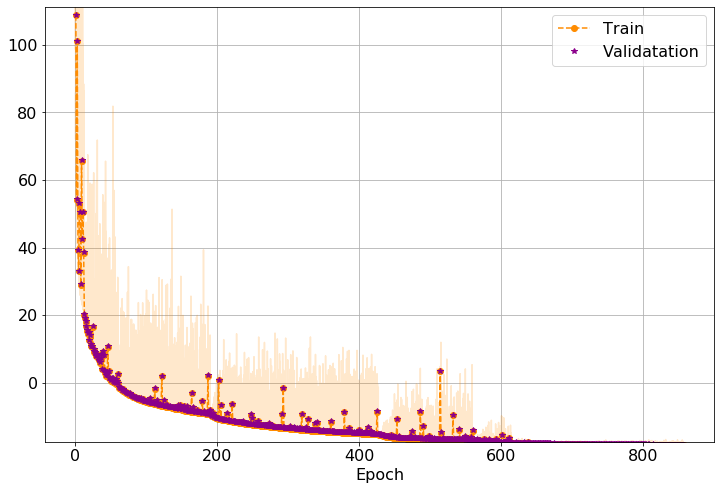

In [19]:
loss_history['train'] = np.array(loss_history['train'])
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(12,8))

train_loss_flat = loss_history['train'].flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(loss_history['train'].shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, loss_history['train'].shape[0]+1)
plt.plot(x, loss_history['train'][:,-1], 'o--', label='Train', color='darkorange')
plt.plot(x, loss_history['val'], '*', label='Validatation', color='darkmagenta')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')
plt.ylim(0.9*np.min(train_loss_flat), 1.1*np.max(loss_history['train'][1:, -1]))

f.savefig('plots/TrainingHistory_dAE_v'+AEversion+'.png')

f = open('data/TrainingHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(loss_history, f)
f.close()

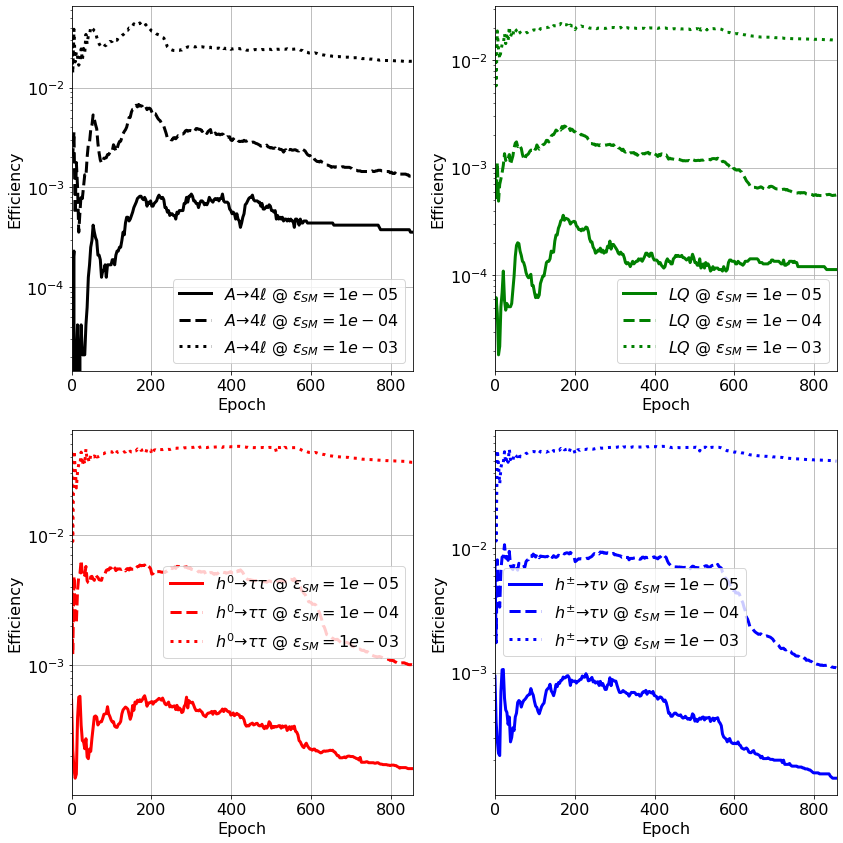

In [20]:
f, ax_arr = plt.subplots(2,2, figsize=(12,12))
styles = ['-', '--', ':']
x = BSM_eff['ep']
for i, n in enumerate(dataset.BSM_names):  
    ax = ax_arr[int(i/2),i%2]
    
    BSM_eff[n] = np.array(BSM_eff[n])
    
    for j in range(BSM_eff['p_SM'].shape[0]):
#         ax.plot(x, len(x)*[BSM_eff['p_SM'][j]], color='gray', lw=2, linestyle=styles[j])
        ax.plot(x, BSM_eff[n][:,j], 
                color=dataset.process_colors[n], lw=3, linestyle=styles[j], 
                label=dataset.process_labels[n] + ' @ $\epsilon_{{SM}} = {:1.0e}$'.format(BSM_eff['p_SM'][j]))
        
    ax.set_xlim([0, x[-1]+1])
#     ax.set_ylim([1e-6, 5])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.grid()
    
    ax.legend(loc='best')
    
f.tight_layout()

f = open('data/AnomalyDetectionHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(BSM_eff, f)
f.close()

In [21]:
# model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_epoch400.pkl'))

# Convergence check

In [22]:
dataset.charge(dataset.SMMix_val)
x = dataset.inputs
model.eval()
if model.onGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

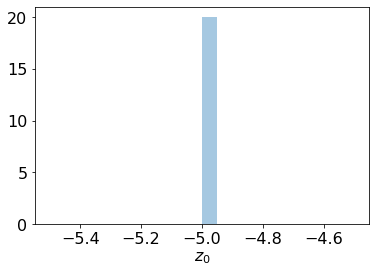

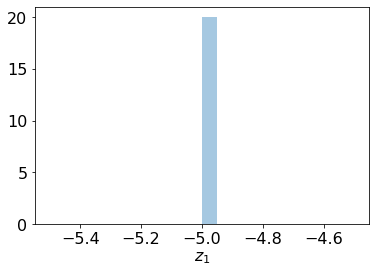

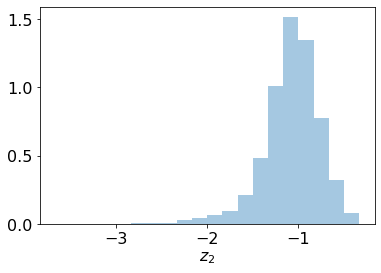

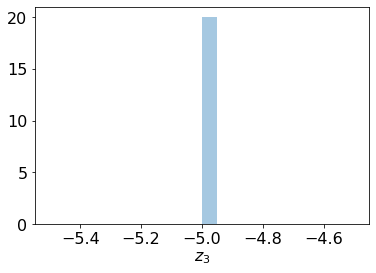

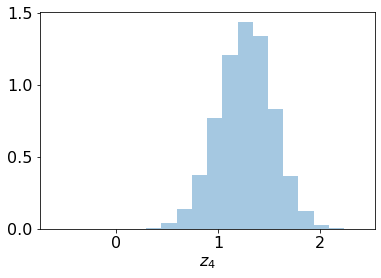

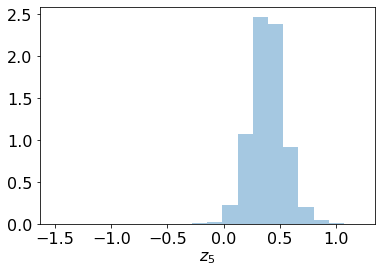

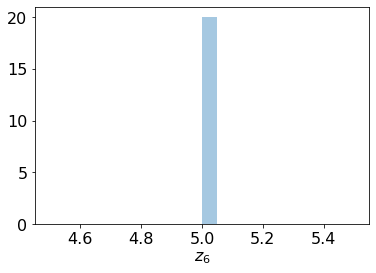

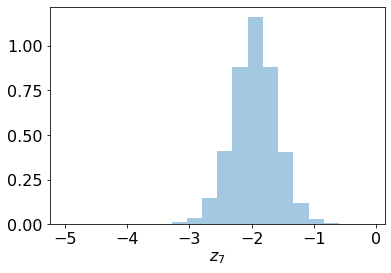

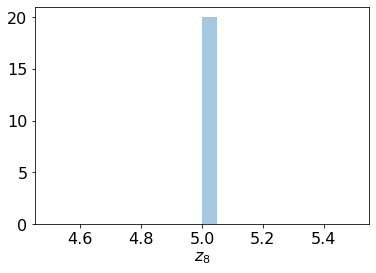

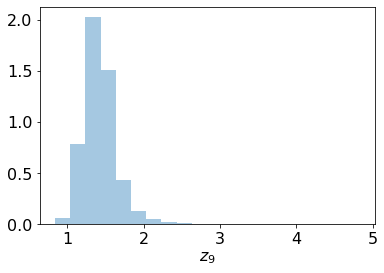

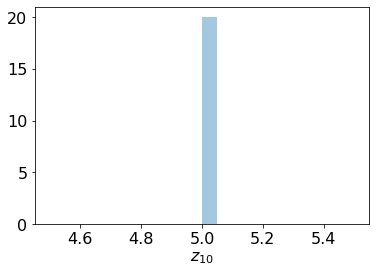

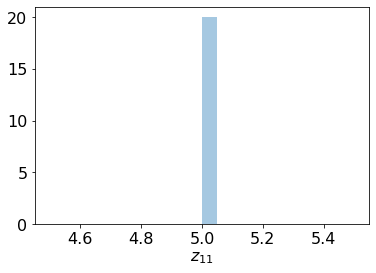

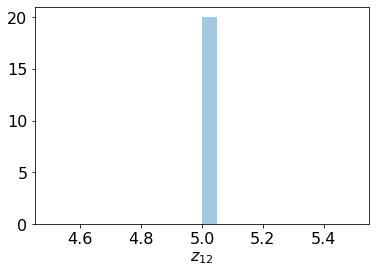

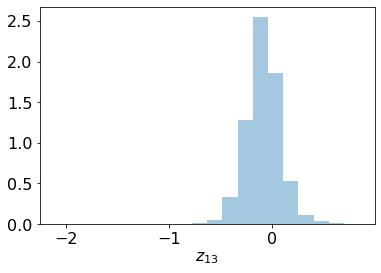

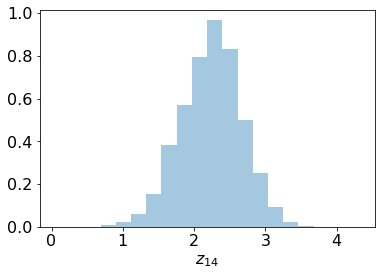

In [34]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

In [35]:
for i in range(x.shape[2]):
    x_aux = x[:,:,i].flatten()
    if i < 3:
        xp_aux = x_prime[:,:,i].flatten()
    elif i==3:
        xp_aux = np.argmax(x_prime[:,:,6:9], axis=2)
        xp_aux = xp_aux.flatten() - 1
    elif i==4:
        xp_aux = np.argmax(x_prime[:,:,9:14], axis=2).flatten()
        
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    if i == 0:
        r = (0,10)
    plt.hist(x_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset.feature_names[i])
#     plt.yscale('log')
    dnd.append(f)

TypeError: min() missing 1 required positional arguments: "dim"

<Figure size 432x288 with 0 Axes>

# Performance evaluation

In [ ]:
dataset.loadValidationSamples('SM')

In [ ]:
model.eval()
for n in list(dataset.valSamples.keys()) + ['SMMix']:
    dataset.loss[n] = np.zeros((0))
    if n == 'SMMix':
        dataset.charge(dataset.SMMix_val)
    else:
        dataset.charge(dataset.valSamples[n])
    
    data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
    for i, (local_x, _) in enumerate(data_iter):
        pb.show(i)
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
            
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
        dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

In [ ]:
plt.figure(figsize=(12,8))
ra = np.array(list(map(lambda x: [np.min(x), np.quantile(x, 1-1e-3)], dataset.loss.values())))
r = (np.min(ra[:,0]), np.max(ra[:,1]))

for n in ['Ato4l','SMMix']:
    plt.hist(dataset.loss[n], bins=31, range=r,
             density=True,
             color=dataset.process_colors[n], 
             alpha=0.3, 
             label=dataset.process_labels[n])
plt.yscale('log')
plt.legend(loc='best')

In [ ]:
dic_ROC = createROC_curve(dataset)
pickle.dump(dic_ROC, open('data/dAE_v{}_ROC_dic.pkl'.format(AEversion), 'wb'))

In [ ]:
f_ROC, ax_arr = plt.subplots(2,2, figsize=(12,12))
for i, n in enumerate(dataset.BSM_names):
    f = open('../data/HLFref1811-10276_loss/VAE_all-in-one_v71_ROC1_dict_{}.pkl'.format(n), 'br')
    dRef = pickle.load(f, encoding='bytes')
    f.close()
    
    ax = ax_arr[int(i/2),i%2]
    ax.plot(dRef[b'eff_SM'], dRef[b'eff_BSM'], label=dataset.process_labels[n] + ' HLF',
            linestyle='--', lw=3, color=dataset.process_colors[n])
    ax.plot(dic_ROC[n]['eff_SM'], dic_ROC[n]['eff_BSM'], label=dataset.process_labels[n] + ' PF',
            linestyle='-', lw=3, color=dataset.process_colors[n])
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':')
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([1e-6, 1.05])
    ax.set_xlabel('SM efficiency')
    ax.set_ylabel('BSM efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    
    ax.legend(loc='lower right')
    
f_ROC.tight_layout()

## Latent dimension clustering

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
dataset.encoded = {}

for n in dataset.BSM_names:    
    dataset.charge(dataset.valSamples[n][:10000])
    x_in = torch.Tensor(dataset.inputs)
    if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
    dataset.encoded[n] = model.encode(x_in).cpu().detach().numpy()
    
dataset.charge(dataset.SMMix_val[:10000])
x_in = torch.Tensor(dataset.inputs)
if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
dataset.encoded['SMMix'] = model.encode(x_in).cpu().detach().numpy()

In [ ]:
idx_max = 1000 #np.min(list(map(lambda x: x.shape[0], dataset.encoded.values())))
z_dset = np.zeros((0, model.Nk))

for n in dataset.encoded.keys():
    z_dset = np.concatenate((z_dset, dataset.encoded[n][:idx_max]))
    
z_embedded = TSNE(n_components=2).fit_transform(z_dset)

In [ ]:
f = plt.figure(figsize=(8,8))

for i, n in enumerate(dataset.encoded.keys()):
#     if not n in ['Ato4l', 'SMMix']: continue
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    plt.plot(aux_z[:,0], aux_z[:,1], 
             'o',
             color=dataset.process_colors[n], 
             mfc='none',
             label=dataset.process_labels[n])
    
plt.xlabel('Embedded 0')
plt.ylabel('Embedded 1')
plt.legend(loc='best')
f.tight_layout()